In [12]:
from sympy import *
import numpy as np
import pandas as pd
from direct_lingam.simulate_data import get_Lambda, simulate_data
from direct_lingam.DAG import plot_dag
import pyximport; pyximport.install(inplace=True)
import multiprocess as mp
from models import ICM
from scipy import optimize

# One latent

Lambda is 
 [[0 0 0]
 [1 0 0]
 [0 1 0]]


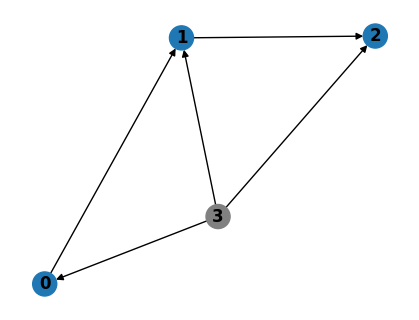

In [13]:
Lambda = get_Lambda([(1,0), (2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1], [1], [1]])
highest_l = 1
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [14]:
import time
def run_experiment(seed):
    # run the experiment using the given parameters
    # Set the random seed
    print(f"Running experiment with seed {seed}")
    noise_distribution = 'gamma'
    samples_sizes = [10**n for n in range(1, 8, 2)]
    n_max = int(max(samples_sizes))
    # p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]
    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = true_B[2, 1]

    # Perform the experiment
    causal_effect_estimate = []
    cumulant_with_min = []
    cross_moment_causal_effect_estimate = []

    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        X_sample = X_sample - np.mean(X_sample, axis=0)
        Z, T, Y = X_sample[:, 0], X_sample[:, 1], X_sample[:, 2]

        model = ICM(X_sample, highest_l=highest_l)
        causal_effect_estimate.append(model.estimate_effect())

        init_point = causal_effect_estimate[-1]
        alpha = 1
        YYZ = (Y*Y*Z).mean()
        YTZ = (Y*T*Z).mean()
        TTZ = (T*T*Z).mean()
        YTT = (Y*T*T).mean()
        TTT = (T*T*T).mean()
        a0 = YYZ * YTT
        a1 = -TTT*YYZ - 2*YTZ*YTT
        a2 = TTZ*YTT + 2*YTZ*TTT
        a3 = -TTZ*TTT

        YZZ = (Y*Z*Z).mean()
        TZZ = (T*Z*Z).mean()
        YYT = (Y*Y*T).mean()
        YTT = (Y*T*T).mean()
        TTT = (T*T*T).mean()
        b0 = YZZ*YYT
        b1 = -TZZ*YYT - 2*YTT*YZZ
        b2 = YZZ*TTT + 2*YTT*TZZ
        b3 = -TZZ*TTT

        cov21 = (Y*T).mean()
        cov20 = (Y*Z).mean()
        cov11 = (T*T).mean()
        cov10 = (T*Z).mean()

        def f_min_reg(x):
            # global alpha
            # global a0
            # global a1
            # global a2
            # global a3
            # global b0
            # global b1
            # global b2
            # global b3
            # global cov21
            # global cov20
            # global cov11
            # global cov10
            # global init_

            k = (a0 + a1*x + a2*x*x + a3*x*x*x) / (b0 + b1*x + b2*x*x + b3*x*x*x)

            return (x - (cov21 - k*cov20) / (cov11-k*cov10))**2 + alpha*(x - init_point)**2

        sol = optimize.minimize(f_min_reg, init_point, method='BFGS')
        beta_est = sol.x[0]
        cumulant_with_min.append(beta_est)

        cross_moment_causal_effect_estimate.append(model.estimate_effect_cross_moment())

    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),
        'Sample Size': samples_sizes,
        'True Effect': [causal_effect_true] * len(samples_sizes),
        'Effect Estimate': causal_effect_estimate,
        'Cross Moment Effect Estimate': cross_moment_causal_effect_estimate,
        'Minimization': cumulant_with_min,
    })
    return seed_df

def parallel_simulation(reps):
    with mp.Pool(processes=4) as pool:
        seeds = range(reps)
        results = pool.map(run_experiment, seeds)

    return pd.concat(results, ignore_index=True)

results_df = parallel_simulation(100)
print("Simulations finished")

def add_grica_exp(results_df):

    samples_sizes = results_df['Sample Size'].unique()
    n_max = int(max(samples_sizes))
    noise_distribution = 'gamma'

    grica_causal_effect_estimate = []
    for seed in results_df['Seed'].unique():

        np.random.seed(seed)
        X, _ = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)

        for n in samples_sizes:
            X_sample = X[:int(n), :]
            X_sample = np.asfortranarray(X_sample)
            X_sample = X_sample - np.mean(X_sample, axis=0)

            model = ICM(X_sample, highest_l=highest_l)
            # print("GRICA with n = ", n)
            # time_start = time.time()
            if n <= 10**5:
                ce_estimate = model.estimate_effect_grica().item()
            grica_causal_effect_estimate.append(ce_estimate)
            # print("Time taken: ", time.time()-time_start)

    results_df['GRICA Effect Estimate'] = grica_causal_effect_estimate
    return results_df

print("GRICA simulation started")
results_df = add_grica_exp(results_df)
print("GRICA simulations ended")

Running experiment with seed 7Running experiment with seed 14Running experiment with seed 21Running experiment with seed 0



Running experiment with seed 8
Running experiment with seed 15
Running experiment with seed 1
Running experiment with seed 22
Running experiment with seed 9
Running experiment with seed 16
Running experiment with seed 2
Running experiment with seed 23
Running experiment with seed 10
Running experiment with seed 17
Running experiment with seed 3
Running experiment with seed 24
Running experiment with seed 11
Running experiment with seed 18
Running experiment with seed 4
Running experiment with seed 25
Running experiment with seed 12
Running experiment with seed 5
Running experiment with seed 19
Running experiment with seed 26
Running experiment with seed 13
Running experiment with seed 6
Running experiment with seed 20
Running experiment with seed 27
Running experiment with seed 28
Running experiment with seed 35
Running experiment with seed 42
Running experiment

In [15]:
results_df.to_csv('Data/cm_with_edge_1_latent.csv', index=False)

In [16]:
results_df = pd.read_csv('Data/cm_with_edge_1_latent.csv')

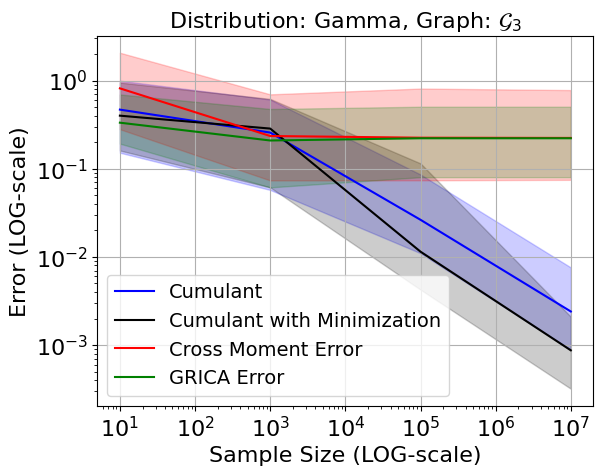

In [18]:
import matplotlib.pyplot as plt

results_df["Error"] = np.abs((results_df['Effect Estimate'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
results_df["Minimization Error"] = np.abs((results_df['Minimization'] - results_df["True Effect"])/results_df["True Effect"])
results_df["Cross Moment Error"] = np.abs((results_df['Cross Moment Effect Estimate'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error
results_df["GRICA Error"] = np.abs((results_df['GRICA Effect Estimate'] - results_df["True Effect"])/results_df["True Effect"])  # Calculate the error

# Group the results by sample size and calculate the mean
median_results = results_df.groupby('Sample Size').median()
quantile_results = results_df.groupby('Sample Size').quantile(0.25)
quantile_results_upper = results_df.groupby('Sample Size').quantile(0.75)


SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(median_results.index, median_results["Error"],
         label='Cumulant',
         color = "blue")

plt.fill_between(median_results.index, quantile_results["Error"], quantile_results_upper["Error"], alpha=0.2, color = "blue")

plt.plot(median_results.index, median_results["Minimization Error"],
         label='Cumulant with Minimization',
         color = "black")

plt.fill_between(median_results.index, quantile_results["Minimization Error"], quantile_results_upper["Minimization Error"], alpha=0.2, color = "black")

plt.plot(median_results.index, median_results["Cross Moment Error"],
            label='Cross Moment Error',
            color = "red")

plt.fill_between(median_results.index, quantile_results["Cross Moment Error"], quantile_results_upper["Cross Moment Error"], alpha=0.2, color = "red")

plt.plot(median_results.index, median_results["GRICA Error"],
            label='GRICA Error',
            color = "green")

plt.fill_between(median_results.index, quantile_results["GRICA Error"], quantile_results_upper["GRICA Error"], alpha=0.2, color = "green")




plt.xlabel('Sample Size (LOG-scale)')
plt.ylabel('Error (LOG-scale)')
plt.title(f"Distribution: Gamma, Graph: $\mathcal{{G}}_3$")
plt.legend()
plt.legend(loc="lower left")
plt.grid()
plt.savefig("Figures/gamma_G3_samples_vs_err.png", bbox_inches="tight")
plt.show()

# Two latents

Lambda is 
 [[0 0 0]
 [1 0 0]
 [0 1 0]]


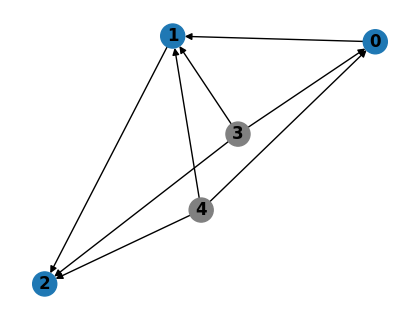

In [6]:
Lambda = get_Lambda([(1,0), (2, 1)], 3)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[1, 1], [1, 1], [1, 1]])
highest_l = 2
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [ ]:
import time
def run_experiment(seed):
    # run the experiment using the given parameters
    # Set the random seed
    print(f"Running experiment with seed {seed}")
    noise_distribution = 'gamma'
    samples_sizes = [10**n for n in range(1, 8, 2)]
    n_max = int(max(samples_sizes))
    # p, q = Lambda.shape[0], Lambda.shape[1]+Gamma.shape[1]
    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = true_B[2, 1]

    # Perform the experiment
    causal_effect_estimate = []
    cross_moment_causal_effect_estimate = []

    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        model = ICM(X_sample, highest_l=highest_l)
        causal_effect_estimate.append(model.estimate_effect())
        cross_moment_causal_effect_estimate.append(model.estimate_effect_cross_moment())

    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),
        'Sample Size': samples_sizes,
        'True Effect': [causal_effect_true] * len(samples_sizes),
        'Effect Estimate': causal_effect_estimate,
        'Cross Moment Effect Estimate': cross_moment_causal_effect_estimate,
    })
    return seed_df

def parallel_simulation(reps):
    pool = mp.Pool(mp.cpu_count())
    seeds = range(reps)
    results = pool.map(run_experiment, seeds)

    pool.close()
    return pd.concat(results, ignore_index=True)

results_df = parallel_simulation(100)

def add_grica_exp(results_df):

    samples_sizes = results_df['Sample Size'].unique()
    n_max = int(max(samples_sizes))
    noise_distribution = 'gamma'

    grica_causal_effect_estimate = []
    for seed in results_df['Seed'].unique():

        np.random.seed(seed)
        X, _ = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)

        for n in samples_sizes:
            X_sample = X[:int(n), :]
            X_sample = np.asfortranarray(X_sample)
            X_sample = X_sample - np.mean(X_sample, axis=0)

            model = ICM(X_sample, highest_l=highest_l)
            print("GRICA with n = ", n)
            time_start = time.time()
            if n <= 10**5:
                ce_estimate = model.estimate_effect_grica().item()
            grica_causal_effect_estimate.append(ce_estimate)
            print("Time taken:", time.time()-time_start, "seconds")

    results_df['GRICA Effect Estimate'] = grica_causal_effect_estimate
    return results_df

results_df_2_latents = add_grica_exp(results_df)

In [8]:
results_df_2_latents.to_csv('Data/cm_with_edge_2_latent.csv', index=False)

In [5]:
results_df_2_latents = pd.read_csv('Data/cm_with_edge_2_latent.csv')

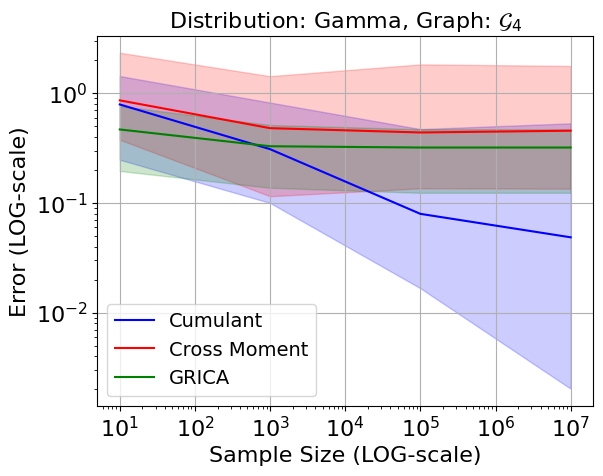

In [8]:
import matplotlib.pyplot as plt

results_df_2_latents["Error"] = np.abs((results_df_2_latents['Effect Estimate'] - results_df_2_latents["True Effect"])/results_df_2_latents["True Effect"])  # Calculate the error
results_df_2_latents["Cross Moment Error"] = np.abs((results_df_2_latents['Cross Moment Effect Estimate'] - results_df_2_latents["True Effect"])/results_df_2_latents["True Effect"])  # Calculate the error
results_df_2_latents["GRICA Error"] = np.abs((results_df_2_latents['GRICA Effect Estimate'] - results_df_2_latents["True Effect"])/results_df_2_latents["True Effect"])  # Calculate the error


# Group the results by sample size and calculate the mean
median_results = results_df_2_latents.groupby('Sample Size').median()
quantile_results = results_df_2_latents.groupby('Sample Size').quantile(0.25)
quantile_results2 = results_df_2_latents.groupby('Sample Size').quantile(0.75)

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(median_results.index, median_results["Error"],
         label='Cumulant',
         color = "blue")

plt.fill_between(median_results.index, quantile_results["Error"], quantile_results2["Error"], alpha=0.2, color = "blue")

plt.plot(median_results.index, median_results["Cross Moment Error"],
            label='Cross Moment',
            color = "red")

plt.fill_between(median_results.index, quantile_results["Cross Moment Error"], quantile_results2["Cross Moment Error"], alpha=0.2, color = "red")

plt.plot(median_results.index, median_results["GRICA Error"],
            label='GRICA',
            color = "green")

plt.fill_between(median_results.index, quantile_results["GRICA Error"], quantile_results2["GRICA Error"], alpha=0.2, color = "green")


plt.xlabel('Sample Size (LOG-scale)')
plt.ylabel('Error (LOG-scale)')
plt.title(f"Distribution: Gamma, Graph: $\mathcal{{G}}_4$")
plt.legend()
plt.legend(loc="lower left")
plt.grid()
plt.savefig("Figures/gamma_G4_samples_vs_err.png", bbox_inches="tight")
plt.show()